**Autoencoders** and **Variational Autoencoders (VAEs)**: for unsupervised learning tasks, particularly for dimensionality reduction, data compression and generative modeling.

**Autoencoders** are NNs designed to encode input data into a lower-dimensional representation and then decode it back to its original form. They consist of two main components:

**Encoder**: This part compresses the input data into a lower-dimensional latent space representation. It learns to capture the essential features of the input data.

**Decoder**: This part reconstructs the input data from the latent space representation. The decoder attempts to reconstruct the input as accurately as possible.

The **autoencoder** is trained to minimize the reconstruction error between the input and the output, using techniques like mean squared error loss.



### Train an autoencoder to generate digits

In [ ]:
import torch
import torchvision
import torchvision.transforms as T

In [ ]:
transform = T.Compose([
    T.ToTensor()])
train_set = torchvision.datasets.MNIST(root = ".",
            train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root = ".",
            train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 108883115.99it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 15584162.33it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27688928.65it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14049062.51it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle= True)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True)

In [ ]:
import torch.nn.functional as F
from torch import nn

device="Cuda" if torch.cuda.is_available() else "cpu"
input_dim = 784
z_dim = 20
h_dim = 200

class AE(nn.Module):
  def __init__(self, input_dim, z_dim, h_dim):
    super().__init__()
    self.common = nn.Linear(input_dim, h_dim)
    self.encoded = nn.Linear(h_dim, z_dim)
    self.ll = nn.Linear(z_dim, h_dim)
    self.decode = nn.Linear(h_dim, input_dim)
  def encoder(self, x):
    common = F.relu(self.common(x))
    mu = self.encoded(common)
    return mu
  def decoder(self, z):
    out = F.relu(self.ll(z))
    out = torch.sigmoid(self.decode(out))
    return out
  def forward(self, x):
    mu = self.encoder(x)
    out = self.decoder(mu)
    return out, mu

In [ ]:
model = AE(input_dim, z_dim, h_dim).to(device)
lr = 0.00025
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [ ]:
import matplotlib.pyplot as plt

# collect a sample for each digit
originals = []
idx = 0
for img, label in test_set:
  if label == idx:
    originals.append(img)
    idx += 1
  if idx == 10:
    break

def test():
  reconstructed = []
  for idx in range(10):
    # reconstruct the digit image
    with torch.no_grad():
      img = originals[idx].reshape((1, input_dim))
      out, mu = model(img.to(device))
    reconstructed.append(out)

  # Plot both the original and the reconstructed
  imgs = originals + reconstructed
  plt.figure(figsize = (10, 2), dpi=50)

  for i in range(20):
    ax = plt.subplot(2, 10, i+1)
    img = (imgs[i].detach().cpu().numpy())
    plt.imshow(img.reshape(28, 28),
                cmap = "binary")
    plt.xticks([])
    plt.yticks([])
  plt.show()

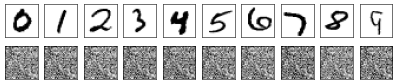

In [ ]:
test()

at epoch 0 toal loss = 1898992.9291687012


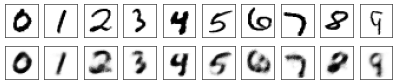

at epoch 1 toal loss = 873931.0266113281


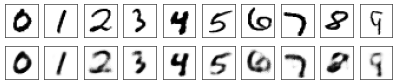

at epoch 2 toal loss = 709887.615020752


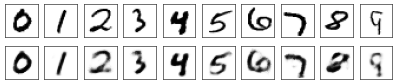

at epoch 3 toal loss = 644591.3678741455


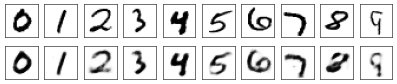

at epoch 4 toal loss = 603385.1321258545


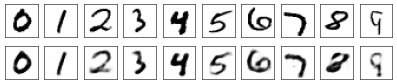

at epoch 5 toal loss = 572315.1368103027


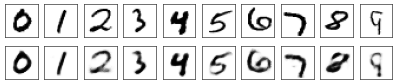

at epoch 6 toal loss = 548263.412979126


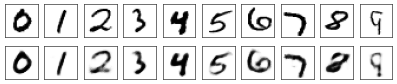

at epoch 7 toal loss = 529118.8225250244


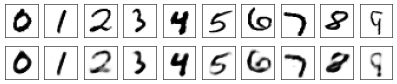

at epoch 8 toal loss = 512980.5812225342


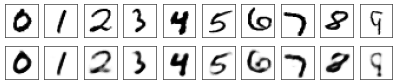

at epoch 9 toal loss = 499271.26080322266


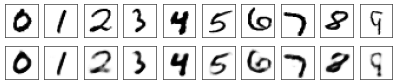

In [ ]:
for epoch in range(10):
  tloss = 0
  for imgs, labels in train_loader:
    # reconstruct the images
    imgs = imgs.to(device).view(-1, input_dim)
    out, mu = model(imgs)
    # reconstruction loss (MSE)
    loss = ((out-imgs)**2).sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    tloss += loss.item()
  print(f"at epoch {epoch} toal loss = {tloss}")

  # visualize the reconstructed digits
  test()


In [ ]:
# Export to TorchScript
scripted = torch.jit.script(model)
# Save the model
scripted.save('/content/AEdigits.pt')

In [ ]:
model=torch.jit.load('/content/AEdigits.pt',map_location=device)
model.eval()

RecursiveScriptModule(
  original_name=AE
  (common): RecursiveScriptModule(original_name=Linear)
  (encoded): RecursiveScriptModule(original_name=Linear)
  (ll): RecursiveScriptModule(original_name=Linear)
  (decode): RecursiveScriptModule(original_name=Linear)
)

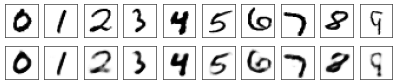

In [ ]:
test()

## VAEs


**VAEs** a type of autoencoder that extends the basic autoencoder architecture by adding a probabilistic twist. They view the latent space as a probability distribution, allowing for more flexible and robust generation of data.

VAEs consist of:
**Encoder**: Similar to the traditional autoencoder, the encoder maps the input data to a latent space. However, instead of directly outputting a point in the latent space, it outputs parameters of a probability distribution (typically Gaussian).

**Decoder**: The decoder takes samples from the latent space distribution and generates data points. This introduces stochasticity into the generation process.

The training of VAEs involves maximizing a lower bound on the log-likelihood of the data, which consists of two parts:
the *reconstruction loss* (similar to traditional autoencoders) and a *regularization* term that encourages the latent space to follow a prior distribution (usually Gaussian).